cuda:0
the initial variables are {'u': 0}
[OK] <JMIRuntime><value name="build_date">"Feb 24 2021"</value> <value name="build_time">"21:25:41"</value></JMIRuntime>
[WARNING] <ModelicaMessage category="warning"><value name="msg">"... loading ""tab1"" from ""/home/lesong/Energym_runs/1670321506_1318722/resources/0/weather.mos""&##10;"</value></ModelicaMessage>
the initial variables are {'u': 0}
the initial variables are {'u': 0}
[OK] <JMIRuntime><value name="build_date">"Feb 24 2021"</value> <value name="build_time">"21:25:41"</value></JMIRuntime>
[WARNING] <ModelicaMessage category="warning"><value name="msg">"... loading ""tab1"" from ""/home/lesong/Energym_runs/1670321513_1307326/resources/0/weather.mos""&##10;"</value></ModelicaMessage>
layer info  [256, 256, 256, 1]
layer info  [256, 256, 256, 1]
the initial variables are {'u': 0}
[OK] <JMIRuntime><value name="build_date">"Feb 24 2021"</value> <value name="build_time">"21:25:41"</value></JMIRuntime>
[WARNING] <ModelicaMessage categor

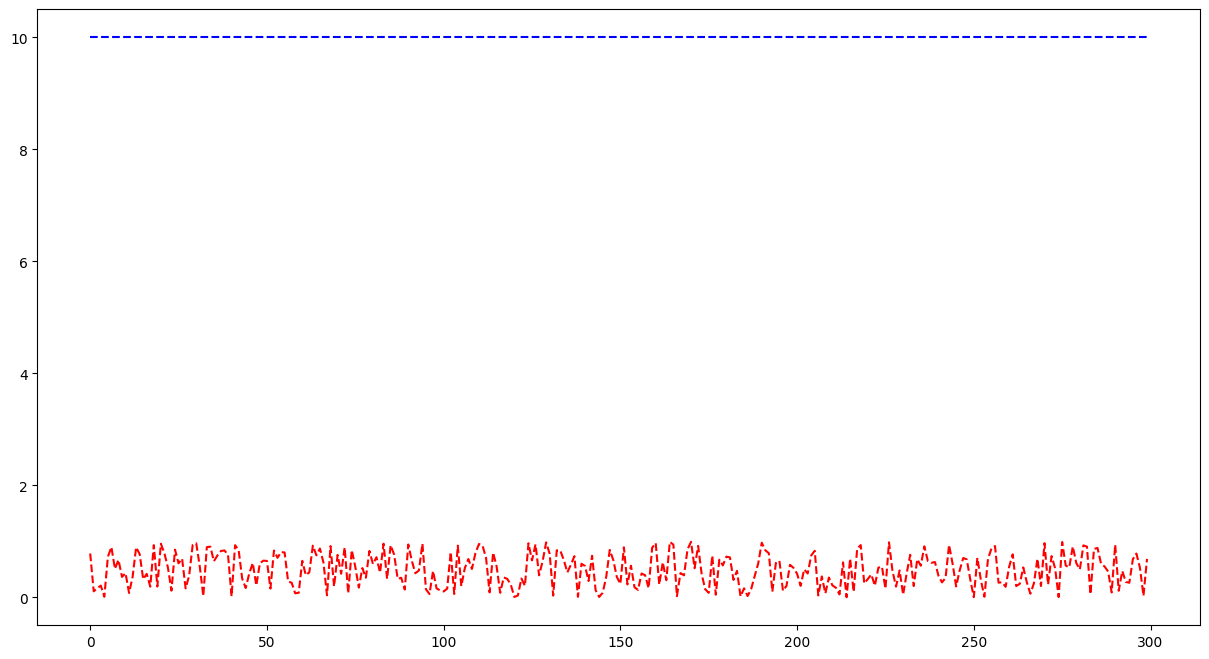

[[ 1. nan]
 [nan nan]]


/anaconda/envs/env39/lib/python3.9/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/anaconda/envs/env39/lib/python3.9/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [1]:
import sys
sys.path.insert(0, "./")

from preference_data import *
from reward_model import *
import torch
import numpy as np
import matplotlib.pyplot as plt
from buildings_factory import *


# buildings_list = ["ApartmentsThermal-v0", "ApartmentsGrid-v0", "Apartments2Thermal-v0",
#                   "Apartments2Grid-v0", "OfficesThermostat-v0", "MixedUseFanFCU-v0",
#                   "SeminarcenterThermostat-v0", "SeminarcenterFull-v0", "SimpleHouseRad-v0",
#                   "SimpleHouseRSla-v0", "SwissHouseRSlaW2W-v0", "SwissHouseRSlaTank-v0"] 


building_name = "SwissHouseRSlaTank-v0"
min_kpis, max_kpis = collect_baseline_kpi(building_name)
building_idx = buildings_list.index(building_name)
env = get_env(building_name)
inputs = get_inputs(building_name, env)
default_control = default_controls[building_idx]
env_rl = StableBaselinesRLWrapper(building_name, min_kpis, max_kpis, reward_func)
input_dim = env_rl.observation_space.shape[0]
model = RewardNet(input_dim)
model_loc = f"data/models/{building_name}/"
model.load_state_dict(torch.load(f"{model_loc}/reward_model/reward_model_best.pkl"))
new_traj_reward_list = []
old_traj_reward_list = []
model.eval()
controller = controller_list[building_idx]
trajectory = sample_trajectory(env_rl, building_name, controller=None)
traj_len = min(300, len(trajectory) // 4)
for i in range(traj_len):
    state, action, old_reward, kpis, next_state = trajectory[4*i], trajectory[4*i+1], trajectory[4*i+2], trajectory[4*i+3], trajectory[4*i+4]
    # old_reward = reward_func(min_kpis, max_kpis, kpis)
    # print(old_reward, kpis)
    # print('cur_state: ', env_rl.inverse_transform_state(state))
    # print("next_state: ", env_rl.inverse_transform_state(next_state))
    old_traj_reward_list.append(old_reward)
    with torch.no_grad():
        # tran = np.concatenate((state, action, next_state))
        model_in = torch.from_numpy(np.array(state)).reshape(1, -1).to(torch.float)
        new_reward = model.get_reward(model_in)[0].item()
    new_traj_reward_list.append(new_reward)

plt.figure(figsize=(15, 8))
x = list(range(len(old_traj_reward_list)))
plt.plot(x, old_traj_reward_list, 'r--', x, new_traj_reward_list, 'b--')
# plt.plot(new_traj_reward_list, 'b--')
plt.show()
print(np.corrcoef(old_traj_reward_list, new_traj_reward_list))